In [1]:
# install.packages("ggplot2")
# install.packages("ggthemes")
# install.packages("ggmosaic")
# install.packages("gridExtra")
# install.packages("repr")
# install.packages("fastDummies")
# install.packages("Amelia")

In [2]:
library(tidyverse)
library(ggthemes)
library(ggmosaic)
library(gridExtra)
library(data.table)
library(fastDummies)
library(Amelia)

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.2.1     v purrr   0.3.2
v tibble  2.1.1     v dplyr   0.8.3
v tidyr   1.0.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine


Attaching package: 'data.table'

The following objects are masked from 'package:dplyr':

    between, first, last

The following object is masked from 'package:purrr':

    transpose

Loading required package: Rcpp
## 
## Amelia II: Multiple Imputation
## (Version 1.7.6, built: 2019-11-24)
## Copyright (C) 2005-2019 James Honaker, Gary King and Matthew Blackwell
## Refer to http://gking.harvard.edu/amelia/ for more in

In [3]:
df_train_iden <- read.csv("train_identity.csv")
df_train_trans <- read.csv("train_transaction.csv")
df_test_iden <- read.csv("test_identity.csv")
df_test_trans <- read.csv("test_transaction.csv")

In [4]:
head(df_train_iden)

TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<fct>,<dbl>,<fct>,<fct>,<lgl>,<lgl>,<lgl>,<lgl>,<fct>,<fct>
2987004,0,70787,NA,NA,NA,NA,NA,NA,NA,...,samsung browser 6.2,32,2220x1080,match_status:2,TRUE,FALSE,TRUE,TRUE,mobile,SAMSUNG SM-G892A Build/NRD90M
2987008,-5,98945,NA,NA,0,-5,NA,NA,NA,...,mobile safari 11.0,32,1334x750,match_status:1,TRUE,FALSE,FALSE,TRUE,mobile,iOS Device
2987010,-5,191631,0,0,0,0,NA,NA,0,...,chrome 62.0,NA,,,FALSE,FALSE,TRUE,TRUE,desktop,Windows
2987011,-5,221832,NA,NA,0,-6,NA,NA,NA,...,chrome 62.0,NA,,,FALSE,FALSE,TRUE,TRUE,desktop,
2987016,0,7460,0,0,1,0,NA,NA,0,...,chrome 62.0,24,1280x800,match_status:2,TRUE,FALSE,TRUE,TRUE,desktop,MacOS
2987017,-5,61141,3,0,3,0,NA,NA,3,...,chrome 62.0,24,1366x768,match_status:2,TRUE,FALSE,TRUE,TRUE,desktop,Windows


In [5]:
head(df_train_trans)

TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
<int>,<int>,<int>,<dbl>,<fct>,<int>,<dbl>,<dbl>,<fct>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2987000,0,86400,68.5,W,13926,NA,150,discover,142,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2987001,0,86401,29.0,W,2755,404,150,mastercard,102,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2987002,0,86469,59.0,W,4663,490,150,visa,166,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2987003,0,86499,50.0,W,18132,567,150,mastercard,117,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2987004,0,86506,50.0,H,4497,514,150,mastercard,102,...,0,0,0,0,0,0,0,0,0,0
2987005,0,86510,49.0,W,5937,555,150,visa,226,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [6]:
print(paste('train_identity:', dim(df_train_iden)[1], 'Rows and', dim(df_train_iden)[2], 'Columns'))
print(paste('test_identity:', dim(df_test_iden)[1], 'Rows and', dim(df_test_iden)[2], 'Columns'))
print(paste('train_transaction:', dim(df_train_trans)[1], 'Rows and', dim(df_train_trans)[2], 'Columns'))
print(paste('test_transaction:', dim(df_test_trans)[1], 'Rows and', dim(df_test_trans)[2], 'Columns'))

[1] "train_identity: 144233 Rows and 41 Columns"
[1] "test_identity: 141907 Rows and 41 Columns"
[1] "train_transaction: 590540 Rows and 394 Columns"
[1] "test_transaction: 506691 Rows and 393 Columns"


In [7]:
df_train <- left_join(df_train_trans, df_train_iden)
df_test <- left_join(df_test_trans, df_test_iden)

dim(df_train) %>% print
dim(df_test) %>% print

rm(df_train_iden, df_train_trans, df_test_iden, df_test_trans)

Joining, by = "TransactionID"
Joining, by = "TransactionID"


[1] 590540    434
[1] 506691    433


In [8]:
missing_train <- colSums(is.na(df_train))[colSums(is.na(df_train)) > 0] %>% sort(decreasing=T)
missing_test <- colSums(is.na(df_test))[colSums(is.na(df_test)) > 0] %>% sort(decreasing=T)

In [9]:
print(paste(length(missing_train), 'columns out of', ncol(df_train), 'have missing values in train'))
print(paste(length(missing_test), 'columns out of', ncol(df_test), 'have missing values in test'))

[1] "409 columns out of 434 have missing values in train"
[1] "380 columns out of 433 have missing values in test"


In [10]:
df_train$key <- "train"
df_test$key <- "test"
full <- bind_rows(df_train, df_test)
rm(df_train, df_test)

Warning message in bind_rows_(x, .id):
"Unequal factor levels: coercing to character"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"Unequal factor levels: coercing to character"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"Unequal factor levels: coercing to character"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"Unequal factor levels: coercing to character"Warning mess

In [11]:
str(full)

'data.frame':	1097231 obs. of  435 variables:
 $ TransactionID : int  2987000 2987001 2987002 2987003 2987004 2987005 2987006 2987007 2987008 2987009 ...
 $ isFraud       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ TransactionDT : int  86400 86401 86469 86499 86506 86510 86522 86529 86535 86536 ...
 $ TransactionAmt: num  68.5 29 59 50 50 ...
 $ ProductCD     : Factor w/ 5 levels "C","H","R","S",..: 5 5 5 5 2 5 5 5 2 5 ...
 $ card1         : int  13926 2755 4663 18132 4497 5937 12308 12695 2803 17399 ...
 $ card2         : num  NA 404 490 567 514 555 360 490 100 111 ...
 $ card3         : num  150 150 150 150 150 150 150 150 150 150 ...
 $ card4         : Factor w/ 5 levels "","american express",..: 3 4 5 4 4 5 5 5 5 4 ...
 $ card5         : num  142 102 166 117 102 226 166 226 226 224 ...
 $ card6         : chr  "credit" "credit" "debit" "debit" ...
 $ addr1         : num  315 325 330 476 420 272 126 325 337 204 ...
 $ addr2         : num  87 87 87 87 87 87 87 87 87 87 ...
 $ dist1         : nu

In [12]:
df_dataType <- data.frame(table(sapply(full, class)))

In [13]:
names(df_dataType)[1] <- "dType"

In [14]:
df_dataType

dType,Freq
<fct>,<int>
character,8
factor,12
integer,4
logical,12
numeric,399


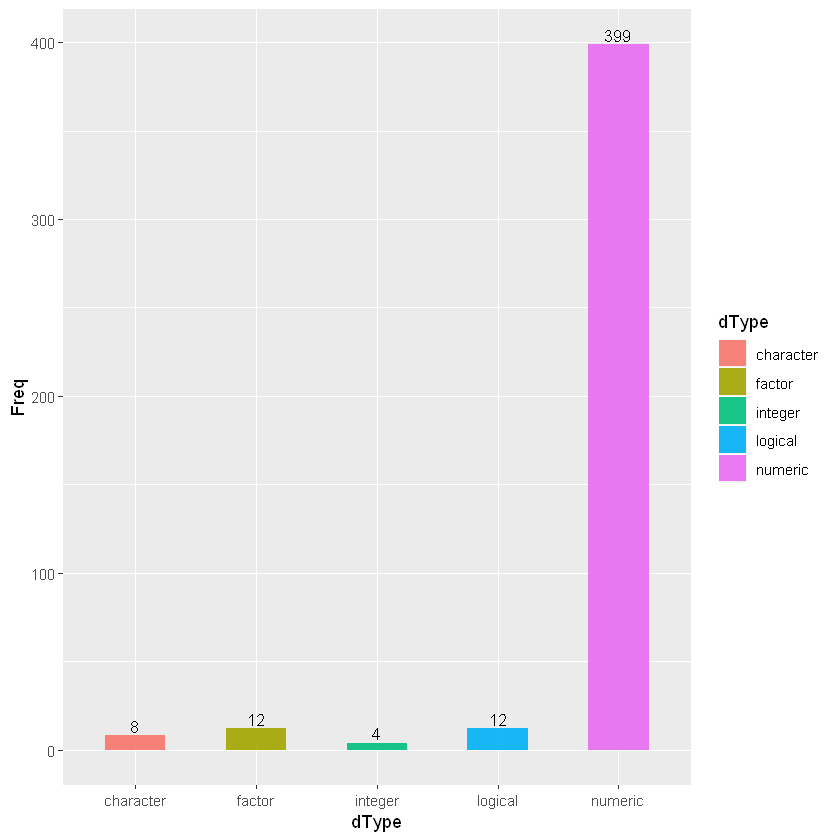

In [15]:
ggplot(data = df_dataType, aes(x=dType, y=Freq, fill=dType)) +
    geom_bar(position = 'dodge', stat='identity', alpha=0.9, width=0.5) +
    geom_text(aes(label=Freq), position=position_dodge(width=0.9), vjust=-0.25, size=3.5)

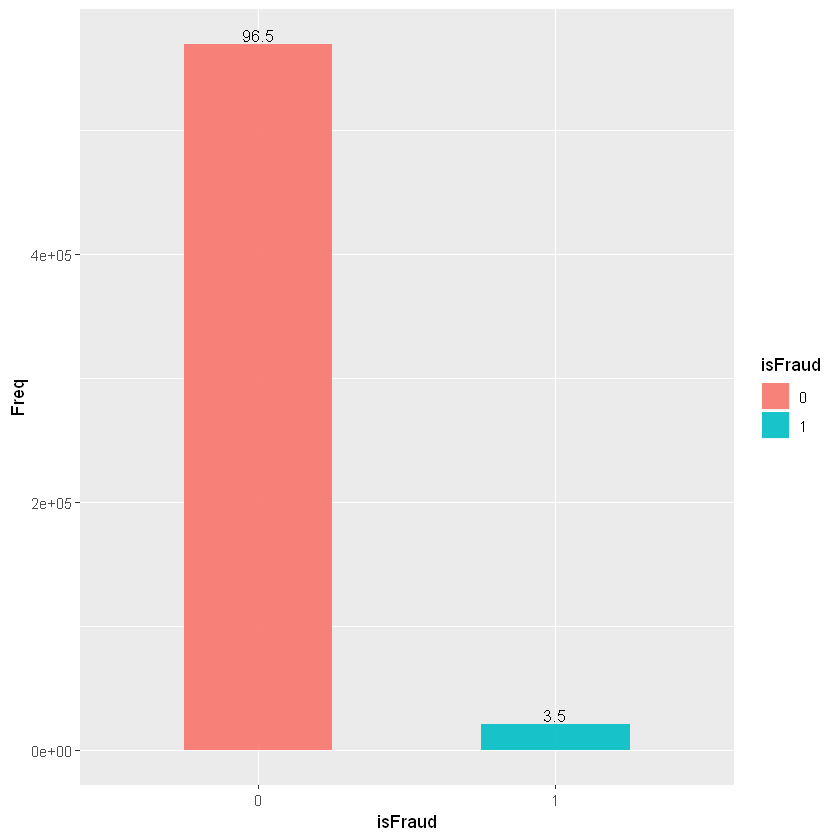

In [16]:
df_isFraud <- data.frame(table(full$isFraud))
names(df_isFraud)[1] <- "isFraud"

ggplot(data = df_isFraud, aes(x=isFraud, y=Freq, fill=isFraud)) +
geom_bar(position = 'dodge', stat='identity', alpha=0.9, width=0.5) +
geom_text(aes(label=round(Freq/sum(Freq)*100, 2)), position=position_dodge(width=0.9), vjust=-0.25, size=3.5)


In [17]:
table(full$DeviceType, useNA = 'ifany')


        desktop  mobile    <NA> 
   8399  159568  118173  811091 

In [18]:
full$DeviceType[full$DeviceType == ''] <- sum(sapply(full['DeviceType'], as.character)=="", na.rm=T)

Warning message in `[<-.factor`(`*tmp*`, full$DeviceType == "", value = 8399L):
"invalid factor level, NA generated"

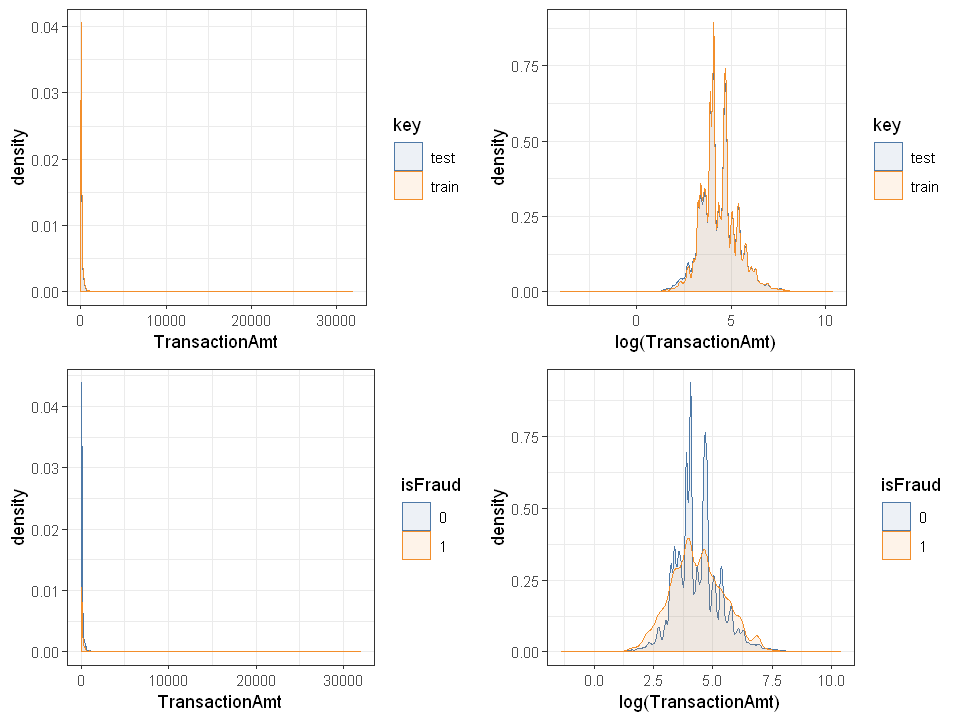

In [19]:
options(repr.plot.width=8, repr.plot.height=6) 
p1 <- full %>% ggplot(aes(x= TransactionAmt, fill=key, colour=key)) + 
    geom_density(alpha=0.1, size=0.2) +
    scale_fill_tableau() + scale_color_tableau() + theme_bw()
p2 <- full %>% ggplot(aes(x= log(TransactionAmt), fill=key, colour=key)) + 
    geom_density(alpha=0.1, size=0.2) +
    scale_fill_tableau() + scale_color_tableau() + theme_bw()
p3 <- full %>% filter(key=='train') %>% ggplot(aes(x= TransactionAmt, fill=factor(isFraud), colour=factor(isFraud))) + 
    geom_density(alpha=0.1, size=0.2) +
    scale_fill_tableau() + scale_color_tableau() + theme_bw() + labs(fill='isFraud') + labs(colour='isFraud')
p4 <- full %>% filter(key=='train') %>% ggplot(aes(x= log(TransactionAmt), fill=factor(isFraud), colour=factor(isFraud))) + 
    geom_density(alpha=0.1, size=0.2) +
    scale_fill_tableau() + scale_color_tableau() + theme_bw() + labs(fill='isFraud') + labs(colour='isFraud')
grid.arrange(p1, p2, p3, p4, ncol=2)
rm(p1, p2, p3, p4)

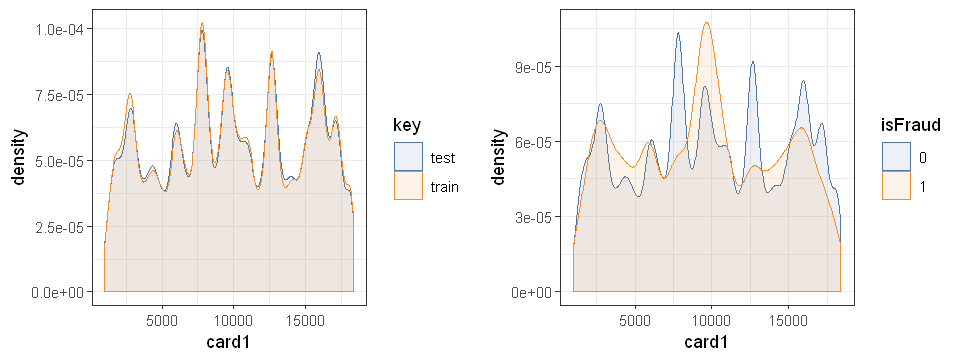

In [20]:
options(repr.plot.width=8, repr.plot.height=3)
p1 <- full %>% ggplot(aes(x= card1, fill=key, colour=key)) + 
    geom_density(alpha=0.1, size=0.2) +
    scale_fill_tableau() + scale_color_tableau() + theme_bw()
p2 <- full %>% filter(key=='train') %>% ggplot(aes(x= card1, fill=factor(isFraud), colour=factor(isFraud))) + 
    geom_density(alpha=0.1, size=0.2) +
    scale_fill_tableau() + scale_color_tableau() + theme_bw() + labs(fill='isFraud') + labs(colour='isFraud')
grid.arrange(p1, p2, ncol=2)
rm(p1, p2)

Warning message:
"Removed 17587 rows containing non-finite values (stat_density)."Warning message:
"Removed 8933 rows containing non-finite values (stat_density)."

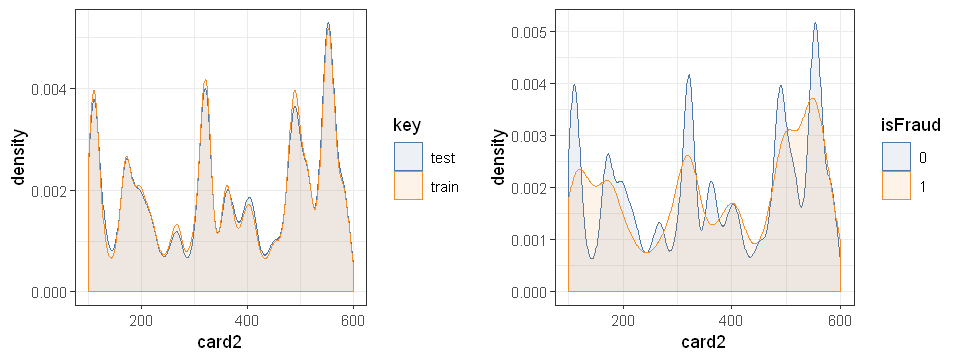

In [21]:
options(repr.plot.width=8, repr.plot.height=3)
p1 <- full %>% ggplot(aes(x= card2, fill=key, colour=key)) + 
    geom_density(alpha=0.1, size=0.2) +
    scale_fill_tableau() + scale_color_tableau() + theme_bw()
p2 <- full %>% filter(key=='train') %>% ggplot(aes(x= card2, fill=factor(isFraud), colour=factor(isFraud))) + 
    geom_density(alpha=0.1, size=0.2) +
    scale_fill_tableau() + scale_color_tableau() + theme_bw() + labs(fill='isFraud') + labs(colour='isFraud')
grid.arrange(p1, p2, ncol=2)
rm(p1, p2)

Warning message:
"Removed 4567 rows containing non-finite values (stat_density)."Warning message:
"Removed 1565 rows containing non-finite values (stat_density)."

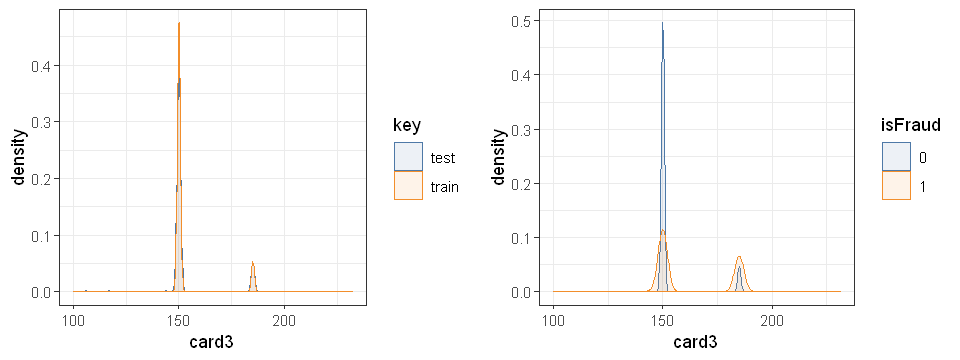

In [22]:
options(repr.plot.width=8, repr.plot.height=3)
p1 <- full %>% ggplot(aes(x= card3, fill=key, colour=key)) + 
    geom_density(alpha=0.1, size=0.2) +
    scale_fill_tableau() + scale_color_tableau() + theme_bw()
p2 <- full %>% filter(key=='train') %>% ggplot(aes(x= card3, fill=factor(isFraud), colour=factor(isFraud))) + 
    geom_density(alpha=0.1, size=0.2) +
    scale_fill_tableau() + scale_color_tableau() + theme_bw() + labs(fill='isFraud') + labs(colour='isFraud')
grid.arrange(p1, p2, ncol=2)
rm(p1, p2)

In [23]:
table(full$card4, useNA = "ifany")


                 american express         discover       mastercard 
            4663            16009             9524           347386 
            visa 
          719649 

In [24]:
full$card4[full$card4 == ''] <- 'NA' LALA

ERROR: Error in parse(text = x, srcfile = src): <text>:1:38: unexpected symbol
1: full$card4[full$card4 == ''] <- 'NA' LALA
                                         ^


In [ ]:
options(repr.plot.width=6, repr.plot.height=3) # resize plot option
full %>% group_by(key, card4) %>% summarise(Freq=n()) %>% ggplot(aes(x=card4, y=Freq, fill=key)) +
    geom_bar(position = 'dodge', stat='identity', alpha=0.9, width=0.5) +
    geom_text(aes(label=Freq), position=position_dodge(width=0.9), vjust=-0.25, size=3.5) +
    scale_fill_tableau() +
    theme_bw() + ylim(0, 6e+05) +
    ggtitle('Barplot of card4') +
    theme(plot.title = element_text(hjust=0.5, size=10), # centering and setting font size of plot title
          axis.text = element_text(size=8),
          legend.title = element_text(size=8),
          axis.title = element_text(size=8))

In [ ]:
options(repr.plot.width=8, repr.plot.height=3) # resize plot option
p1 <- full %>% ggplot(aes(x= card5, fill=key, colour=key)) + 
    geom_density(alpha=0.1, size=0.2) +
    scale_fill_tableau() + scale_color_tableau() + theme_bw()
p2 <- full %>% filter(key=='train') %>% ggplot(aes(x= card5, fill=factor(isFraud), colour=factor(isFraud))) + 
    geom_density(alpha=0.1, size=0.2) +
    scale_fill_tableau() + scale_color_tableau() + theme_bw() + labs(fill='isFraud') + labs(colour='isFraud')
grid.arrange(p1, p2, ncol=2)
rm(p1, p2)

In [ ]:
options(repr.plot.width=6, repr.plot.height=3) 
full %>% group_by(key, card6) %>% summarise(Freq=n()) %>% ggplot(aes(x=card6, y=Freq, fill=key)) +
    geom_bar(position = 'dodge', stat='identity', alpha=0.9, width=0.5) +
    geom_text(aes(label=Freq), position=position_dodge(width=0.9), vjust=-0.25, size=3.5) +
    scale_fill_tableau() +
    theme_bw() + ylim(0, 6e+05) +
    ggtitle('Barplot of card6') +
    theme(plot.title = element_text(hjust=0.5, size=10),
          axis.text = element_text(size=8),
          legend.title = element_text(size=8),
          axis.title = element_text(size=8))

In [ ]:
missing_rate <- colSums(is.na(full))/nrow(full) 
missing_delVars <- names(missing_rate[missing_rate> 0.95])
full <- full[ , !(names(full) %in% missing_delVars)]

In [ ]:
X_train <- full[full$key=='train', ] %>% select(-TransactionID, -key)
# y_train <- full[full$key=='train', ]$isFraud
X_test <- full[full$key=='test', ] %>% select(-isFraud, -TransactionID, -key)

rm(full)

In [ ]:
cat_vars <- names(X_train)[sapply(X_train, is.character)]
sapply(X_train[cat_vars], function(x) length(unique(x))) %>% sort(decreasing=T) %>% head(10) %>% data.frame

In [ ]:
X_train[, cat_vars] <- lapply(X_train[, cat_vars], as.factor)
X_test[, cat_vars] <- lapply(X_test[, cat_vars], as.factor)

In [ ]:
X_train[, cat_vars] <- lapply(X_train[, cat_vars], as.integer)
X_test[, cat_vars] <- lapply(X_test[, cat_vars], as.integer)

In [ ]:
print(dim(X_train))
print(dim(X_test))

In [ ]:
head(X_train)

In [ ]:
colnames(X_train)[colSums(is.na(X_train)) > 0]

In [ ]:
model1 <- glm(isFraud~., family=binomial(link='logit'), data = X_train)
summary(model1)